<a href="https://colab.research.google.com/github/george-zakharov/ml_notebooks/blob/master/PCA_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Homework 7



#### Light: 

Датасет: https://www.kaggle.com/uciml/red-wine-quality-cortez-et-al-2009
(из Homework 6)

С помощью алгоритма PCA найти размерность пространства признаков до которой можно понизить исходное пространство без потери точности.


#### Pro: 

Датасет: https://www1.nyc.gov/html/gbee/html/plan/ll84_scores.shtml
(из Homework 4)

С помощью алгоритма PCA (t-SNE) найти размерность пространства признаков до которой можно понизить исходное пространство без потери точности.

# Load Libs

In [0]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

# Compression libs
from sklearn import decomposition
from sklearn.manifold import TSNE


# Normalization tests
from scipy.stats import kurtosis
from scipy.stats import skew
from scipy.stats import shapiro
from scipy.stats import normaltest

# Data normalization / standartization
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler

# libs for train tuning
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split

# Data resampling
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

# Boosting
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier

# Model parameters fitting
from sklearn.model_selection import GridSearchCV

# Metrics
from sklearn.metrics import accuracy_score, auc, f1_score, confusion_matrix,precision_score, recall_score, roc_auc_score, roc_curve, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, LinearRegression, LassoCV, Lasso, Ridge, SGDRegressor
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.svm import LinearSVR
import sys

# Light

## Load dataset

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
wine = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/6/data/winequality-red.csv')

In [5]:
wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


## User defined functions

In [0]:
def get_upsampled_wine_data(wine_preprocessed):
  # Get data classes for further balancing
  wine_3 = wine_preprocessed[wine_preprocessed.quality == 3]
  wine_4 = wine_preprocessed[wine_preprocessed.quality == 4]
  wine_5 = wine_preprocessed[wine_preprocessed.quality == 5]
  wine_6 = wine_preprocessed[wine_preprocessed.quality == 6]
  wine_7 = wine_preprocessed[wine_preprocessed.quality == 7]
  wine_8 = wine_preprocessed[wine_preprocessed.quality == 8]

  # Use upsampling (based on the previous work best results)

  # Transform classes
  wine_3_upsampled = resample(wine_3, replace = True, n_samples = len(wine_5), random_state = 42)
  wine_4_upsampled = resample(wine_4, replace = True, n_samples = len(wine_5), random_state = 42)
  wine_6_upsampled = resample(wine_6, replace = True, n_samples = len(wine_5), random_state = 42)
  wine_7_upsampled = resample(wine_7, replace = True, n_samples = len(wine_5), random_state = 42)
  wine_8_upsampled = resample(wine_8, replace = True, n_samples = len(wine_5), random_state = 42)

  wine_upsampled = pd.concat([wine_5, wine_3_upsampled, wine_4_upsampled, wine_6_upsampled, wine_7_upsampled, wine_8_upsampled])

  X_ups = wine_upsampled.drop('quality', axis = 1)
  y_ups = wine_upsampled.quality

  return X_ups, y_ups

In [0]:
# Train model and get accuracy score
def train_and_get_accuracy(X_train, y_train, X_test, y_test):
  model = XGBClassifier(
    base_score = 0.5, booster = 'gbtree', colsample_bylevel = 1, colsample_bynode = 1,
    colsample_bytree = 1, gamma = 0, learning_rate = 0.1, max_delta_step = 0, max_depth = 3,
    min_child_weight = 1, missing = None, n_estimators = 100, n_jobs = 1, nthread = None,
    objective = 'binary:logistic', random_state = 0, reg_alpha = 0, reg_lambda = 1,
    scale_pos_weight = 1, seed = None, silent = None, subsample = 1, verbosity = 1
  )

  model.fit(X_train, y_train)

  # make predictions for test data
  y_pred = model.predict(X_test)
  predictions = [round(value) for value in y_pred]

  # evaluate predictions
  accuracy = accuracy_score(y_test, predictions)
  result = "Accuracy: %.2f%%" % (accuracy * 100.0)
  return result

In [0]:
# Functions for normalization test
def draw_hist_for_feature(data):
  plt.style.use('ggplot')
  data.hist(bins = 60)
  plt.show()


def chech_skew(feature):
  method_name = '\nSKEW TEST: '
  skew_ = np.abs(skew(feature))
  if (skew_ >= 0.75) and (skew_ < 1.0):
    print(method_name + 'Данные рекомендуется логарифмировать\n')
  elif skew_ >= 1:
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def check_shapiro(feature):
  method_name = '\nSHAPIRO TEST: '
  shapiro_ = np.abs(shapiro(feature))
  if (shapiro_[1] < 0.50):
    print(method_name + 'Данные рекомендуется нормализовать\n')
  else:
    print(method_name + 'Данные достаточно стандартизировать\n')


def print_stats(data, need_hist = True):
  if (need_hist == True):
    draw_hist_for_feature(data)

  print("mean : ", np.mean(data))
  print("var  : ", np.var(data))
  print("skew : ", skew(data))
  print("kurt : ", kurtosis(data))
  print("shapiro : ", shapiro(data))
  print("normaltest : ", normaltest(data))


def print_stats_all(df, need_hist = True):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    print_stats(df[feature_name], need_hist)
    chech_skew(df[feature_name])
    check_shapiro(df[feature_name])
    n += 1

In [0]:
# Data preprocessing according to skew metrics
def data_preprocessing(df):
  n = 1
  for feature_name in df.columns:
    print(f'\n\n{n}. {feature_name}')
    feature = df[feature_name]

    print_stats(feature)
    
    skew_ = np.abs(skew(feature))

    if (skew_ >= 0.75) and (skew_ < 1.0):
      print('\nДанные рекомендуется логарифмировать\n')
      feature = np.log(feature)
    elif skew_ >= 1:
      if feature.min() > 0:
        print('\nДанные рекомендуется нормализовать методом boxcox\n')
        box_cox_transform = PowerTransformer(method = 'box-cox', standardize = False)
        feature = box_cox_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
      else:
        print('\nДанные рекомендуется нормализовать методом yeo-johnson\n')
        yeo_johnson_transform = PowerTransformer(method = 'yeo-johnson', standardize = False)
        feature = yeo_johnson_transform.fit_transform(feature.values.reshape(df.shape[0], -1))
    else:
      print('\nДанные достаточно стандартизировать\n')

    print_stats(pd.DataFrame(feature, columns = [feature_name]))
    chech_skew(feature)

    df[feature_name] = feature

    n += 1

  return df

In [0]:
# Data standartization
def scale_std_minmax(df):
  print(df.shape)

  scaler = StandardScaler()
  print(scaler.fit(df.copy()))
  StandardScaler()
  result = scaler.transform(df.copy())
  result = pd.DataFrame(result, columns = df.columns)


  scaler = MinMaxScaler()
  print(scaler.fit(result))
  MinMaxScaler(copy = True, feature_range = (0, 1))
  print(scaler.data_max_)
  result = scaler.transform(result)
  result = pd.DataFrame(result, columns = df.columns)
  
  return result

## Dataset transformations

In [0]:
# Divide features and labels
X = wine.drop(['quality'], axis = 1)
y = wine.quality



1. fixed acidity


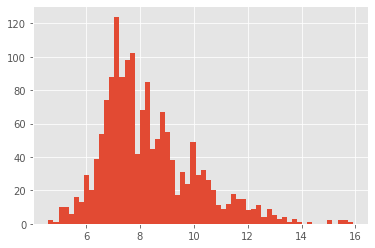

mean :  8.319637273295838
var  :  3.0295205688671296
skew :  0.9818292953262073
kurt :  1.1248563352037486
shapiro :  (0.942030668258667, 1.5255951637239901e-24)
normaltest :  NormaltestResult(statistic=224.53087840457746, pvalue=1.7528277735470436e-49)

Данные рекомендуется логарифмировать



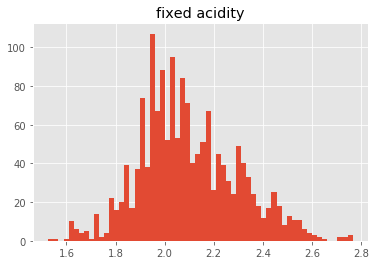

mean :  fixed acidity    2.098226
dtype: float64
var  :  fixed acidity    0.03974
dtype: float64
skew :  [0.39354537]
kurt :  [0.09695618]
shapiro :  (0.9848697185516357, 6.456312047486978e-12)
normaltest :  NormaltestResult(statistic=array([39.54165981]), pvalue=array([2.59201595e-09]))

SKEW TEST: Данные достаточно стандартизировать



2. volatile acidity


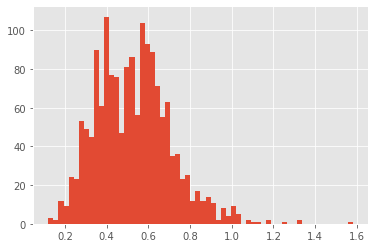

mean :  0.5278205128205131
var  :  0.03204232613332036
skew :  0.6709623963499574
kurt :  1.2179633893005306
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=143.4193435598286, pvalue=7.192589039756692e-32)

Данные достаточно стандартизировать



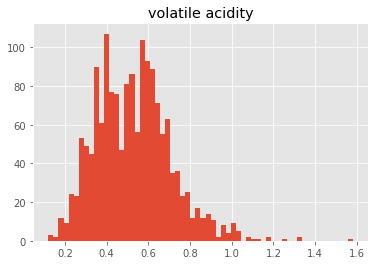

mean :  volatile acidity    0.527821
dtype: float64
var  :  volatile acidity    0.032042
dtype: float64
skew :  [0.6709624]
kurt :  [1.21796339]
shapiro :  (0.9743340611457825, 2.686806772838566e-16)
normaltest :  NormaltestResult(statistic=array([143.41934356]), pvalue=array([7.19258904e-32]))

SKEW TEST: Данные достаточно стандартизировать



3. citric acid


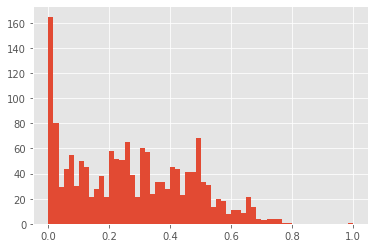

mean :  0.2709756097560964
var  :  0.037923751124940605
skew :  0.3180385895475358
kurt :  -0.7902825153036646
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=152.039214793795, pvalue=9.662822259281018e-34)

Данные достаточно стандартизировать



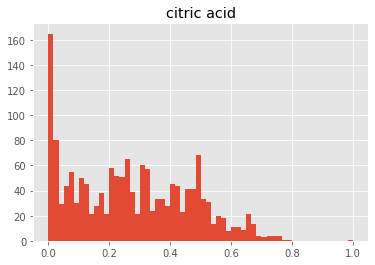

mean :  citric acid    0.270976
dtype: float64
var  :  citric acid    0.037924
dtype: float64
skew :  [0.31803859]
kurt :  [-0.79028252]
shapiro :  (0.9552900195121765, 1.0208196357632134e-21)
normaltest :  NormaltestResult(statistic=array([152.03921479]), pvalue=array([9.66282226e-34]))

SKEW TEST: Данные достаточно стандартизировать



4. residual sugar


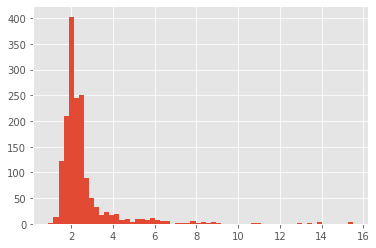

mean :  2.5388055034396517
var  :  1.9866539202699018
skew :  4.536394788805638
kurt :  28.524437824252235
shapiro :  (0.5660765171051025, 0.0)
normaltest :  NormaltestResult(statistic=1520.3239698236891, pvalue=0.0)

Данные рекомендуется нормализовать методом boxcox



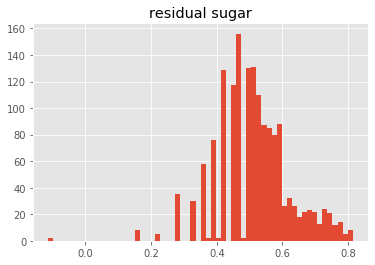

mean :  residual sugar    0.513556
dtype: float64
var  :  residual sugar    0.01211
dtype: float64
skew :  [-0.09584002]
kurt :  [1.60404381]
shapiro :  (0.9759386777877808, 1.011885569943366e-15)
normaltest :  NormaltestResult(statistic=array([62.41154248]), pvalue=array([2.80224271e-14]))

SKEW TEST: Данные достаточно стандартизировать



5. chlorides


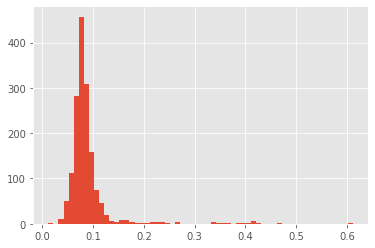

mean :  0.08746654158849257
var  :  0.0022137573233114395
skew :  5.675016527504259
kurt :  41.581708043675775
shapiro :  (0.4842468500137329, 0.0)
normaltest :  NormaltestResult(statistic=1783.1059225626427, pvalue=0.0)

Данные рекомендуется нормализовать методом boxcox



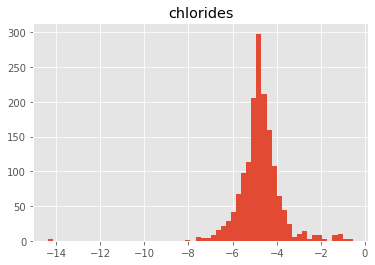

mean :  chlorides   -4.763474
dtype: float64
var  :  chlorides    0.926346
dtype: float64
skew :  [-0.49917442]
kurt :  [14.5513695]
shapiro :  (0.8716785907745361, 2.4586373518860107e-34)
normaltest :  NormaltestResult(statistic=array([412.77325778]), pvalue=array([2.33037565e-90]))

SKEW TEST: Данные достаточно стандартизировать



6. free sulfur dioxide


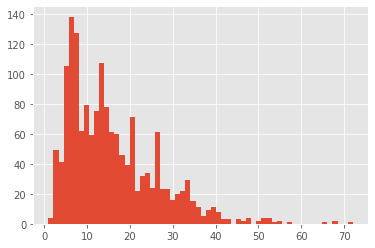

mean :  15.874921826141339
var  :  109.3464567637451
skew :  1.249393847434253
kurt :  2.01348999733378
shapiro :  (0.9018407464027405, 7.6973984391279615e-31)
normaltest :  NormaltestResult(statistic=342.2591484251238, pvalue=4.779365332171477e-75)

Данные рекомендуется нормализовать методом boxcox



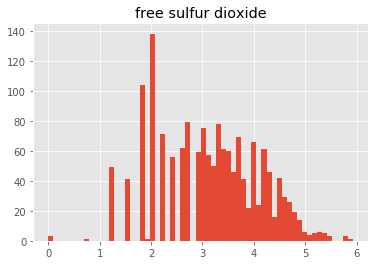

mean :  free sulfur dioxide    3.129049
dtype: float64
var  :  free sulfur dioxide    0.971227
dtype: float64
skew :  [-0.01975919]
kurt :  [-0.59777277]
shapiro :  (0.9874722361564636, 1.5522860774552782e-10)
normaltest :  NormaltestResult(statistic=array([49.9466963]), pvalue=array([1.42630598e-11]))

SKEW TEST: Данные достаточно стандартизировать



7. total sulfur dioxide


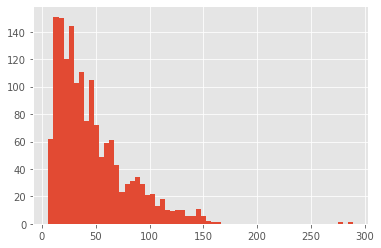

mean :  46.46779237023139
var  :  1081.4256355891553
skew :  1.5141091878506638
kurt :  3.7941717664905665
shapiro :  (0.8732253909111023, 3.5741436086741964e-34)
normaltest :  NormaltestResult(statistic=487.42725648953467, pvalue=1.433890834343538e-106)

Данные рекомендуется нормализовать методом boxcox



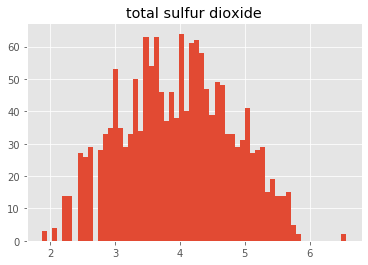

mean :  total sulfur dioxide    3.965719
dtype: float64
var  :  total sulfur dioxide    0.715565
dtype: float64
skew :  [-0.00802061]
kurt :  [-0.67038533]
shapiro :  (0.990358293056488, 8.859659672566522e-09)
normaltest :  NormaltestResult(statistic=array([71.36209297]), pvalue=array([3.19093827e-16]))

SKEW TEST: Данные достаточно стандартизировать



8. density


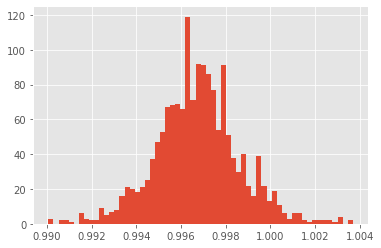

mean :  0.9967466791744831
var  :  3.559801792630711e-06
skew :  0.07122077153539946
kurt :  0.9274107990478333
shapiro :  (0.9908668398857117, 1.9400959061499634e-08)
normaltest :  NormaltestResult(statistic=30.70774994095191, pvalue=2.1473202738102222e-07)

Данные достаточно стандартизировать



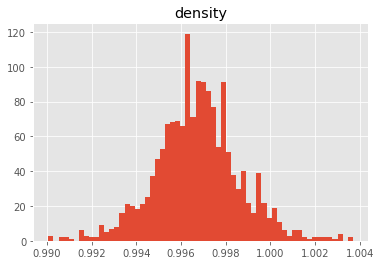

mean :  density    0.996747
dtype: float64
var  :  density    0.000004
dtype: float64
skew :  [0.07122077]
kurt :  [0.9274108]
shapiro :  (0.9908668398857117, 1.9400959061499634e-08)
normaltest :  NormaltestResult(statistic=array([30.70774994]), pvalue=array([2.14732027e-07]))

SKEW TEST: Данные достаточно стандартизировать



9. pH


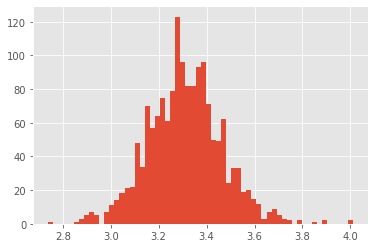

mean :  3.311113195747343
var  :  0.023820274241131745
skew :  0.19350175891005525
kurt :  0.8006714441211544
shapiro :  (0.993486762046814, 1.7136950418716879e-06)
normaltest :  NormaltestResult(statistic=33.684697471483915, pvalue=4.8468645347727716e-08)

Данные достаточно стандартизировать



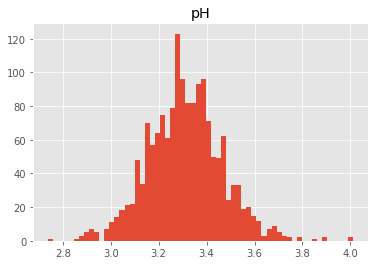

mean :  pH    3.311113
dtype: float64
var  :  pH    0.02382
dtype: float64
skew :  [0.19350176]
kurt :  [0.80067144]
shapiro :  (0.993486762046814, 1.7136950418716879e-06)
normaltest :  NormaltestResult(statistic=array([33.68469747]), pvalue=array([4.84686453e-08]))

SKEW TEST: Данные достаточно стандартизировать



10. sulphates


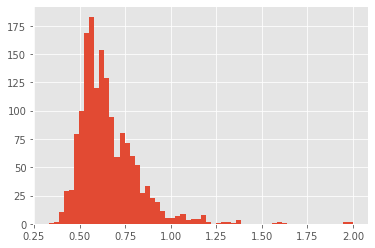

mean :  0.6581488430268921
var  :  0.028714647013983425
skew :  2.426393455449087
kurt :  11.6798841115311
shapiro :  (0.8330425024032593, 5.821617678881608e-38)
normaltest :  NormaltestResult(statistic=906.8944479227036, pvalue=1.1759065222978855e-197)

Данные рекомендуется нормализовать методом boxcox



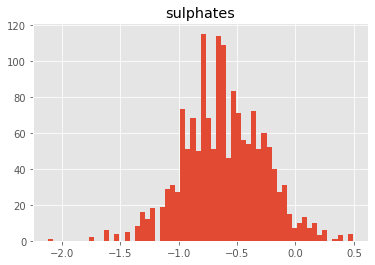

mean :  sulphates   -0.609663
dtype: float64
var  :  sulphates    0.115999
dtype: float64
skew :  [-0.02475606]
kurt :  [0.39890141]
shapiro :  (0.9964831471443176, 0.0010049439733847976)
normaltest :  NormaltestResult(statistic=array([8.24567945]), pvalue=array([0.01619845]))

SKEW TEST: Данные достаточно стандартизировать



11. alcohol


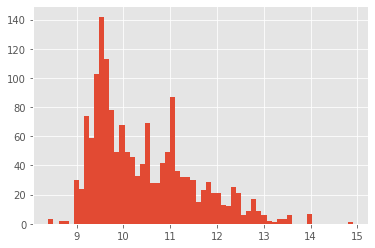

mean :  10.422983114446502
var  :  1.1349371714888994
skew :  0.8600210646566755
kurt :  0.1956543762123122
shapiro :  (0.9288389682769775, 6.643664824998876e-27)
normaltest :  NormaltestResult(statistic=154.17806951912516, pvalue=3.3163288473185496e-34)

Данные рекомендуется логарифмировать



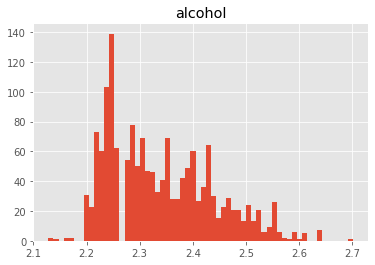

mean :  alcohol    2.339021
dtype: float64
var  :  alcohol    0.009775
dtype: float64
skew :  [0.66123544]
kurt :  [-0.28947897]
shapiro :  (0.9464339017868042, 1.154532723556871e-23)
normaltest :  NormaltestResult(statistic=array([105.75210886]), pvalue=array([1.08697946e-23]))

SKEW TEST: Данные достаточно стандартизировать



In [11]:
# Normalization
X_normalized = data_preprocessing(X)

In [12]:
# Standartization
X_scaled = scale_std_minmax(X_normalized)

(1599, 11)
StandardScaler(copy=True, with_mean=True, with_std=True)
MinMaxScaler(copy=True, feature_range=(0, 1))
[3.35136224 5.87797605 3.74357393 2.72895662 4.37508071 2.83835204
 3.07267011 3.68005512 4.52828197 3.23051437 3.66487349]


In [0]:
# Prepare train / test data
wine_preprocessed = pd.concat([X_scaled, y], axis = 1)

In [15]:
wine_preprocessed.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.383325,0.397260,0.00,0.607134,0.683397,0.483927,0.423477,0.567548,0.606299,0.504120,0.196252,5
1,0.425771,0.520548,0.00,0.739835,0.739956,0.692260,0.599486,0.494126,0.362205,0.628770,0.268963,5
2,0.425771,0.438356,0.04,0.693719,0.726509,0.559731,0.542857,0.508811,0.409449,0.602052,0.268963,5
3,0.717475,0.109589,0.56,0.607134,0.680266,0.591301,0.570440,0.582232,0.330709,0.528593,0.268963,6
4,0.383325,0.397260,0.00,0.607134,0.683397,0.483927,0.423477,0.567548,0.606299,0.504120,0.196252,5


In [0]:
# Split features and labels (after normalization & standartization)
X = wine_preprocessed.drop('quality', axis = 1)
y = wine_preprocessed.quality

In [0]:
# Disbalanced dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
# Check labels count
wine_preprocessed.quality.value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

In [0]:
X_ups, y_ups = get_upsampled_wine_data(wine_preprocessed)

In [0]:
X_train_ups, X_test_ups, y_train_ups, y_test_ups = train_test_split(X_ups, y_ups, test_size = 0.2, random_state = 42)

## Train and PCA use

In [25]:
# Use model based on previous work best results
train_and_get_accuracy(X_train_ups, y_train_ups, X_test_ups, y_test_ups)

'Accuracy: 82.89%'

In [26]:
X.shape

(1599, 11)

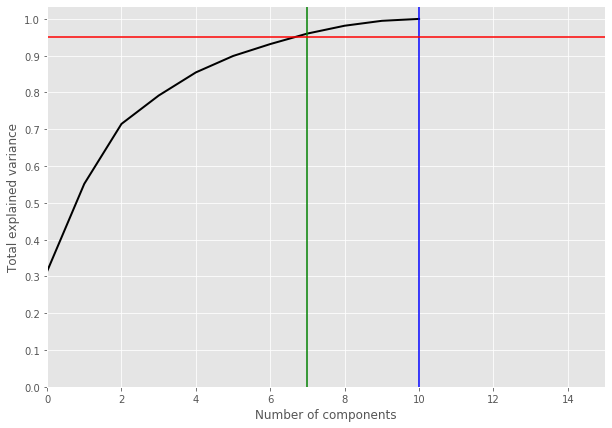

In [27]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize = (10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'k', lw = 2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 15)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(10, c = 'b')
plt.axvline(7, c = 'g', ls = '-')
plt.axhline(0.95, c = 'r')
plt.show();

In [28]:
np.cumsum(pca.explained_variance_ratio_)

array([0.3136648 , 0.55171673, 0.71459223, 0.79165751, 0.85461648,
       0.89921754, 0.93163379, 0.96023803, 0.98147133, 0.99481206,
       1.        ])

In [0]:
# With dispersion of 0.95 features can be compressed to 7 from 11
pca = decomposition.PCA(n_components = 7)
X_reduced = pca.fit_transform(X)

In [30]:
X_reduced.shape

(1599, 7)

In [0]:
X_reduced_df = pd.DataFrame(X_reduced)

In [42]:
X_reduced_df.head()

,0,1,2,3,4,5,6
0,-0.268228,-0.008343,-0.274758,-0.019410,-0.069423,0.010938,-0.045702
1,-0.225280,-0.255354,-0.137577,-0.122590,-0.032140,-0.208872,0.038397
2,-0.179989,-0.130177,-0.159575,-0.067744,-0.042668,-0.127054,0.035465
3,0.387149,-0.181626,0.029808,0.163405,0.118911,0.025121,-0.057808
4,-0.268228,-0.008343,-0.274758,-0.019410,-0.069423,0.010938,-0.045702


In [0]:
wine_reduced = pd.concat([X_reduced_df, y], axis = 1)

In [44]:
wine_reduced.head()

,0,1,2,3,4,5,6,quality
0,-0.268228,-0.008343,-0.274758,-0.019410,-0.069423,0.010938,-0.045702,5
1,-0.225280,-0.255354,-0.137577,-0.122590,-0.032140,-0.208872,0.038397,5
2,-0.179989,-0.130177,-0.159575,-0.067744,-0.042668,-0.127054,0.035465,5
3,0.387149,-0.181626,0.029808,0.163405,0.118911,0.025121,-0.057808,6
4,-0.268228,-0.008343,-0.274758,-0.019410,-0.069423,0.010938,-0.045702,5


In [0]:
X_ups_reduced, y_ups_reduced = get_upsampled_wine_data(wine_reduced)

In [0]:
X_train_ups_reduced, X_test_ups_reduced, y_train_ups_reduced, y_test_ups_reduced = train_test_split(X_ups_reduced, y_ups_reduced, test_size = 0.2, random_state = 42)

In [53]:
train_and_get_accuracy(X_train_ups_reduced, y_train_ups_reduced, X_test_ups_reduced, y_test_ups_reduced)

'Accuracy: 83.62%'

As we can see, accuracy on reduced dataset is even better than on the full one

# Pro

## Load Dataset

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

In [0]:
# Read in data into a dataframe 
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/ML/4/Блокноты/Homework 4/Energy_and_Water_Data_Disclosure_for_Local_Law_84_2017__Data_for_Calendar_Year_2016_.csv')

In [55]:
data.head()

,Order,Property Id,Property Name,Parent Property Id,Parent Property Name,BBL - 10 digits,"NYC Borough, Block and Lot (BBL) self-reported",NYC Building Identification Number (BIN),Address 1 (self-reported),Address 2,Postal Code,Street Number,Street Name,Borough,DOF Gross Floor Area,Primary Property Type - Self Selected,List of All Property Use Types at Property,Largest Property Use Type,Largest Property Use Type - Gross Floor Area (ft²),2nd Largest Property Use Type,2nd Largest Property Use - Gross Floor Area (ft²),3rd Largest Property Use Type,3rd Largest Property Use Type - Gross Floor Area (ft²),Year Built,Number of Buildings - Self-reported,Occupancy,Metered Areas (Energy),Metered Areas (Water),ENERGY STAR Score,Site EUI (kBtu/ft²),Weather Normalized Site EUI (kBtu/ft²),Weather Normalized Site Electricity Intensity (kWh/ft²),Weather Normalized Site Natural Gas Intensity (therms/ft²),Weather Normalized Source EUI (kBtu/ft²),Fuel Oil #1 Use (kBtu),Fuel Oil #2 Use (kBtu),Fuel Oil #4 Use (kBtu),Fuel Oil #5 & 6 Use (kBtu),Diesel #2 Use (kBtu),District Steam Use (kBtu),Natural Gas Use (kBtu),Weather Normalized Site Natural Gas Use (therms),Electricity Use - Grid Purchase (kBtu),Weather Normalized Site Electricity (kWh),Total GHG Emissions (Metric Tons CO2e),Direct GHG Emissions (Metric Tons CO2e),Indirect GHG Emissions (Metric Tons CO2e),Property GFA - Self-Reported (ft²),Water Use (All Water Sources) (kgal),Water Intensity (All Water Sources) (gal/ft²),Source EUI (kBtu/ft²),Release Date,Water Required?,DOF Benchmarking Submission Status,Latitude,Longitude,Community Board,Council District,Census Tract,NTA
0,1,13286,201/205,13286,201/205,1013160001,1013160001,1037549,201/205 East 42nd st.,Not Available,10017,675,3 AVENUE,Manhattan,289356.0,Office,Office,Office,293447,Not Available,Not Available,Not Available,Not Available,1963,2,100,Whole Building,Not Available,Not Available,305.6,303.1,37.8,Not Available,614.2,Not Available,Not Available,Not Available,Not Available,Not Available,5.15506751E7,Not Available,Not Available,38139374.2,1.10827705E7,6962.2,0,6962.2,762051,Not Available,Not Available,619.4,05/01/2017 05:32:03 PM,No,In Compliance,40.750791,-73.973963,6.0,4.0,88.0,Turtle Bay-East Midtown ...
1,2,28400,NYP Columbia (West Campus),28400,NYP Columbia (West Campus),1021380040,1-02138-0040,1084198; 1084387;1084385; 1084386; 1084388; 10...,622 168th Street,Not Available,10032,180,FT WASHINGTON AVENUE,Manhattan,3693539.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),3889181,Not Available,Not Available,Not Available,Not Available,1969,12,100,Whole Building,Whole Building,55,229.8,228.8,24.8,2.4,401.1,Not Available,1.96248472E7,Not Available,Not Available,Not Available,-3.914148026E8,933073441,9330734.4,332365924,9.62613121E7,55870.4,51016.4,4854.1,3889181,Not Available,Not Available,404.3,04/27/2017 11:23:27 AM,No,In Compliance,40.841402,-73.942568,12.0,10.0,251.0,Washington Heights South ...
2,3,4778226,MSCHoNY North,28400,NYP Columbia (West Campus),1021380030,1-02138-0030,1063380,3975 Broadway,Not Available,10032,3975,BROADWAY,Manhattan,152765.0,Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),Hospital (General Medical & Surgical),231342,Not Available,Not Available,Not Available,Not Available,1924,1,100,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,Not Available,0,0,0,231342,Not Available,Not Available,Not Available,04/27/2017 11:23:27 AM,No,In Compliance,40.840427,-73.940249,12.0,10.0,251.0,Washington Heights South ...
3,4,4778267,Herbert Irving Pavilion & Millstein Hospital,28400,NYP Columbia (West Campus),1021390001,1-02139-0001,1087281; 1076746,161 Fort Washington Ave,177 Fort Washington Ave,10032,161,FT WASHINGTON AVENUE,Manhattan,891040.0,Hos

## Data transformation

In [0]:
# Replace all occurrences of Not Available with numpy not a number
data = data.replace({'Not Available': np.nan})

# Iterate through the columns
for col in list(data.columns):
    # Select columns that should be numeric
    if ('ft²' in col or 'kBtu' in col or 'Metric Tons CO2e' in col or 'kWh' in col or 'therms' in col or 'gal' in col or 'Score' in col):
        # Convert the data type to float
        data[col] = data[col].astype(float)

In [0]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [58]:
missing_values_table(data)

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.


,Missing Values,% of Total Values
Fuel Oil #1 Use (kBtu),11737,99.9
Diesel #2 Use (kBtu),11730,99.9
Address 2,11539,98.2
Fuel Oil #5 & 6 Use (kBtu),11152,94.9
District Steam Use (kBtu),10810,92.0
Fuel Oil #4 Use (kBtu),10425,88.8
3rd Largest Property Use Type - Gross Floor Area (ft²),10262,87.4
3rd Largest Property Use Type,10262,87.4
Fuel Oil #2 Use (kBtu),9165,78.0
2nd Largest Property Use Type,8005,68.2


In [59]:
missing_df = missing_values_table(data);
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50].index)
print('We will remove %d columns.' % len(missing_columns))

Your selected dataframe has 60 columns.
There are 46 columns that have missing values.
We will remove 11 columns.


In [0]:
# Drop the columns
data = data.drop(columns = list(missing_columns))

In [61]:
# Copy the original data
features = data.copy()

# Select the numeric columns
numeric_subset = data.select_dtypes('number')

# Create columns with log of numeric columns
for col in numeric_subset.columns:
    # Skip the Energy Star Score column
    if col == 'score':
        next
    else:
        numeric_subset['log_' + col] = np.log(numeric_subset[col])
        
# Select the categorical columns
categorical_subset = data[['Borough', 'Largest Property Use Type']]

# One hot encode
categorical_subset = pd.get_dummies(categorical_subset)

# Join the two dataframes using concat
# Make sure to use axis = 1 to perform a column bind
features = pd.concat([numeric_subset, categorical_subset], axis = 1)

features.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


(11746, 116)

In [62]:
# Extract the buildings with no score and the buildings with a score
no_score = features[features['ENERGY STAR Score'].isna()]
score = features[features['ENERGY STAR Score'].notnull()]

print(no_score.shape)
print(score.shape)

(2104, 116)
(9642, 116)


In [63]:
# Separate out the features and targets
features = score.drop(columns = 'ENERGY STAR Score')
targets = pd.DataFrame(score['ENERGY STAR Score'])

# Replace the inf and -inf with nan (required for later imputation)
features = features.replace({np.inf: np.nan, -np.inf: np.nan})

# Split into 70% training and 30% testing set
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

print(X.shape)
print(X_test.shape)
print(y.shape)
print(y_test.shape)

(7713, 115)
(1929, 115)
(7713, 1)
(1929, 1)


In [0]:
# Replace all occurrences of NaN with python integer max size (for further feature selection)
features = features.replace({np.nan: sys.maxsize})

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


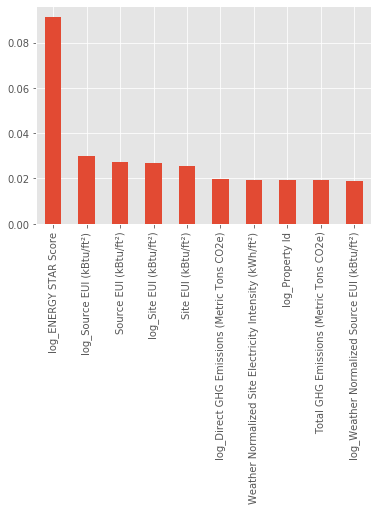

In [70]:
# ExtraTreesClassifier (feature importance)
model = ExtraTreesClassifier()
model.fit(features, targets)

feat_importances = pd.Series(model.feature_importances_, index=features.columns)

et_clf = feat_importances.nlargest(10).index

feat_importances.nlargest(10).plot(kind = 'bar')
plt.show()

In [71]:
# Select features with chi2
bestfeatures = SelectKBest(score_func = chi2, k = 10)
fit = bestfeatures.fit(features.drop(columns = features.columns[(features < 0).any()], axis = 1), targets)

chi2_scores = pd.DataFrame(fit.scores_)

feature_columns = pd.DataFrame(features.drop(columns = features.columns[(features < 0).any()], axis = 1).columns)

features_scores = pd.concat([feature_columns, chi2_scores], axis = 1)

features_scores.columns = ['name', 'score']

feat_chi = features_scores.nlargest(10, 'score').iloc[:, 0]

feat_chi

35           log_Electricity Use - Grid Purchase (kBtu)
14               Electricity Use - Grid Purchase (kBtu)
34                           log_Natural Gas Use (kBtu)
36        log_Weather Normalized Site Electricity (kWh)
9     Weather Normalized Site Electricity Intensity ...
15            Weather Normalized Site Electricity (kWh)
12                               Natural Gas Use (kBtu)
10    Weather Normalized Site Natural Gas Intensity ...
13     Weather Normalized Site Natural Gas Use (therms)
28                             log_DOF Gross Floor Area
Name: name, dtype: object

In [73]:
# Combine top features
et_clf = pd.DataFrame(et_clf)

et_clf = et_clf.values

feat_chi = pd.DataFrame(feat_chi)

feat_chi = feat_chi.values

merged_features = np.concatenate((feat_chi, et_clf))

merged_features = np.unique(merged_features)

merged_features

array(['Electricity Use - Grid Purchase (kBtu)', 'Natural Gas Use (kBtu)',
       'Site EUI (kBtu/ft²)', 'Source EUI (kBtu/ft²)',
       'Total GHG Emissions (Metric Tons CO2e)',
       'Weather Normalized Site Electricity (kWh)',
       'Weather Normalized Site Electricity Intensity (kWh/ft²)',
       'Weather Normalized Site Natural Gas Intensity (therms/ft²)',
       'Weather Normalized Site Natural Gas Use (therms)',
       'log_DOF Gross Floor Area',
       'log_Direct GHG Emissions (Metric Tons CO2e)',
       'log_ENERGY STAR Score',
       'log_Electricity Use - Grid Purchase (kBtu)',
       'log_Natural Gas Use (kBtu)', 'log_Property Id',
       'log_Site EUI (kBtu/ft²)', 'log_Source EUI (kBtu/ft²)',
       'log_Weather Normalized Site Electricity (kWh)',
       'log_Weather Normalized Source EUI (kBtu/ft²)'], dtype=object)

## Standartization

In [0]:
X, X_test, y, y_test = train_test_split(features, targets, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_scl = scaler.fit_transform(X)
X_test_scl = scaler.fit_transform(X_test)

X_scl = pd.DataFrame(X_scl, columns = X.columns)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test.columns)

## Train

In [0]:
lg_model = LinearRegression(copy_X = True, fit_intercept = True, n_jobs = None, normalize = False)

In [76]:
lg_model.fit(X_scl[merged_features], y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
lg_model.score(X_scl[merged_features], y)

0.7690551612743349

In [0]:
preds = lg_model.predict(X_test_scl[merged_features])
mae = mean_absolute_error(y_test, preds.argmax(axis = 1))

In [90]:
mae

60.15966822187662

In [81]:
X.shape

(7713, 115)

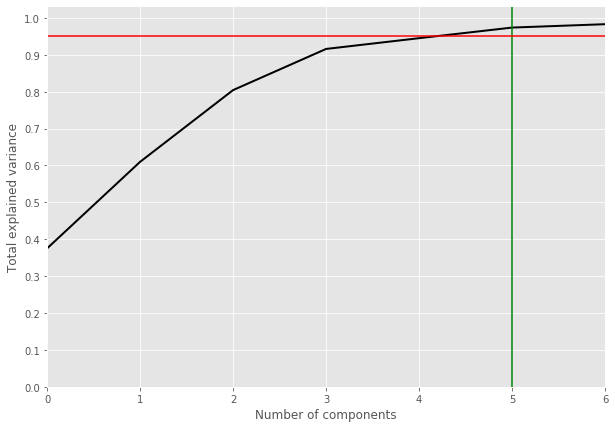

In [126]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize = (10, 7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color = 'k', lw = 2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 6)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(5, c = 'g', ls = '-')
plt.axhline(0.95, c = 'r')
plt.show();

In [85]:
np.cumsum(pca.explained_variance_ratio_)

array([0.38013716, 0.61504001, 0.80660652, 0.91809342, 0.94711897,
       0.97517627, 0.98375126, 0.9890155 , 0.99238051, 0.99548289,
       0.99685527, 0.99793067, 0.99838682, 0.99873078, 0.99904753,
       0.99934233, 0.99951546, 0.99966823, 0.99979756, 0.99990458,
       0.99998074, 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.     

Text(0.5, 1.0, 'EnergySTAR. t-SNE projection')

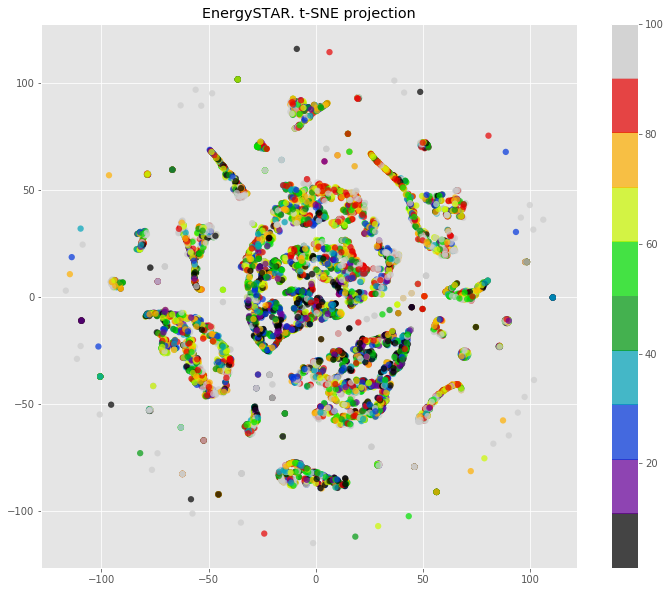

In [128]:
tsne_best = TSNE(random_state = 17)

X_tsne = tsne_best.fit_transform(X)

plt.figure(figsize = (12, 10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c = y.values.flatten(), 
            edgecolor = 'none', alpha = 0.7, s = 40,
            cmap = plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('EnergySTAR. t-SNE projection')

In [0]:
# With dispersion of 0.95 features can be compressed to 5 from 115
pca = decomposition.PCA(n_components = 5)
features_reduced = pca.fit_transform(features)

In [0]:
X, X_test, y, y_test = train_test_split(pd.DataFrame(features_reduced), targets, test_size = 0.2, random_state = 42)

scaler = StandardScaler()

X_scl = scaler.fit_transform(X)
X_test_scl = scaler.fit_transform(X_test)

X_scl = pd.DataFrame(X_scl, columns = X.columns)
X_test_scl = pd.DataFrame(X_test_scl, columns = X_test.columns)

In [134]:
lg_model.fit(X_scl, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [135]:
lg_model.score(X_scl, y)

0.02079024522574746

In [0]:
preds = lg_model.predict(X_test_scl)
mae = mean_absolute_error(y_test, preds.argmax(axis = 1))

In [137]:
mae

60.15966822187662

# Useful links

* https://habr.com/ru/company/ods/blog/325654/
* https://fooobar.com/questions/16311024/analysis-of-wine-quality-dataset
* https://habr.com/ru/post/304214/
* https://habr.com/ru/company/ods/blog/322626/
* https://habr.com/ru/company/ods/blog/323210/
* https://distill.pub/2016/misread-tsne/
* https://www.kaggle.com/sonalisingh1411/pca-on-wine-dataset
* https://goksinan.github.io/machine/pca-on-wine-data/
* http://www.cs.nthu.edu.tw/~shwu/courses/ml/labs/02_EDA_PCA/02_EDA_PCA.html

* https://feature-engine.readthedocs.io/en/latest/index.html